In [98]:
from abc import ABC, abstractclassmethod
from typing import Dict, List, Tuple, Optional
from collections.abc import Callable, Iterable
from dataclasses import dataclass, field
from functools import partial


from random import random, shuffle
from glob import glob


import numpy as np
import pandas as pd
import statistics as stats

from tqdm import tqdm
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [132]:
def load_csv(path: str) -> Dict[str, np.ndarray]:
    """Loads every csv file in the path."""
    dataloader = {file_path.split("/")[-1].split(".")[0]: pd.read_csv(file_path, header=None, sep=" ") for file_path in glob(path+"*.csv")}
    return dataloader

@dataclass
class Model(ABC):
    """Base Representation of a Machine Learning Model."""
    loss: Optional[Callable[[np.ndarray, np.ndarray], np.ndarray]]
    optimizer: Optional[Callable[[np.ndarray, np.ndarray, np.ndarray,], (np.ndarray, float)]]
    hist: Dict[str, List]
    learning_rate: float 
    epochs: int
    eval_step: int
    early_stop: bool
    range_flag: bool
    
    @abstractclassmethod
    def predict(self, X: np.ndarray) -> None:
        """Predicts the out come of Matrix X."""
        pass
        
    @abstractclassmethod
    def update_weights(self, X: np.ndarray, y: np.ndarray) -> None:
        """Updates the weights of the model after one step or epoch."""
        pass
    
    @abstractclassmethod
    def fit(self, X: np.ndarray, y: np.ndarray ) -> None:
        """trains the model using the vector features X and labels Y."""
        pass
    
    @abstractclassmethod
    def save_hist(self, X: np.ndarray, y: np.ndarray, i: int) -> None:
        """Saves the parameters of the model in between updates of training."""
        pass
    
    def plot_training(self) -> go.Figure:
        """Animate the change of prediction of the model on training data with dimension of 1."""
        assert self.range_flag == False
        fig=go.Figure().set_subplots(1,1, vertical_spacing=0.05,
                             specs=[[{"type": "scatter", "secondary_y": False}]])
        
        # first frame of the plot
        fig.add_trace(go.Scatter(x=self.hist["x_range"], y=self.hist["y_range"], name="train", mode='markers'), 1,1)
        fig.add_trace(go.Scatter(x=self.hist["x_range"], y=self.hist["y_range"], name="train", mode='markers'), 1,1);

        fig.update(frames=self.hist["frame"])
        
        # details about the plot layout
        sliders_dict = {"active": 0, "yanchor": "top", "xanchor": "left",
                        "currentvalue": { "font": {"size": 20}, "prefix": "Year:", "visible": True, "xanchor": "right"},
                        "transition": {"duration": 300, "easing": "cubic-in-out"}, "pad": {"b": 10, "t": 50}, "len": 0.9, 
                        "x": 0.1, "y": 0, "steps": []}

        updatemenus_dict = {
                "buttons": [{"args": [None, {"frame": {"duration": 500, "redraw": False}, "fromcurrent": True,
                "transition": {"duration": 300, "easing": "quadratic-in-out"}}], "label": "Play", "method": "animate"},
                {"args": [[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate", "transition": {"duration": 0}}],
                "label": "Pause", "method": "animate"}], "direction": "left", "pad": {"r": 10, "t": 87}, "showactive": True,
                "type": "buttons", "x": 0.1, "xanchor": "right", "y": 0, "yanchor": "top",
                }

        fig.update_layout(sliders=[sliders_dict],
                          updatemenus = [updatemenus_dict])

        return fig
    
    def plot_history(self, keys: Iterable) -> go.Figure:
        """Plots the keys saved in self.hist for each epoch."""
        fig = make_subplots(specs=[[{"secondary_y": True}]])
        for key in keys:
            fig.add_trace(go.Scatter(x=np.arange(stop=self.epochs,),
                                     y=self.hist[key], name=key))
        return fig

    
class Scaler():
    mean: float
    std: float
    def set_standard_scaler(self, X: np.ndarray) -> np.ndarray:
        """Standardize features by removing the mean and scaling to unit variance and save it for prediction time."""
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        standard = (X - self.mean) / self.std

        return standard

    def get_standard_scaler(self, X: np.ndarray) -> np.ndarray:
        """Standardize features by removing the mean of training set and scaling to unit variance of training set."""
        standard = (X - self.mean) / self.std

        return standard

@dataclass
class Layer(ABC):
    input_size: int
    output_size: int

    @abstractclassmethod
    def feed_forward(self, X):
        """computes feed forward of Layer respect to input X"""
        pass

    @abstractclassmethod
    def backward_propagation(self, pred, learning_rate):
        """computes backward propagation of Layer respect to input X"""
        pass
    

@dataclass
class ActivationFunction(Layer):
    activation: Callable[[np.ndarray], np.ndarray]
    activation_prime: Callable[[np.ndarray], np.ndarray]
    
    def random_initializers(self) -> None:
        pass
        
    def feed_forward(self, x) -> np.ndarray:
        self.x = x.copy()
        return self.activation(self.x)

    def backward_propagation(self, dy: np.ndarray) -> np.ndarray:
        dx = self.activation_prime(self.x) * dy
        return dx

@dataclass
class FCLayer(Layer):
    input_size: int
    output_size: int
    activation: Callable[[np.ndarray], np.ndarray]
    activation_prime: Callable[[np.ndarray], np.ndarray]
    
    def random_initializers(self, std=5e-2) -> None:
        """Make a random start for weights and bias"""
        self.weights = std * np.random.randn(self.input_size, self.output_size)
        self.bias =  np.zeros((1, self.output_size))
        
    def feed_forward(self, x: np.ndarray) -> np.ndarray:
        """computes feed forward of Layer respect to input X"""
        # print(f"W.T={self.weights.T.shape}, x.T={x.T.shape}, b= {self.bias.shape}")
        self.x = x.copy()
        self.z =  np.dot(x,self.weights)  + self.bias
        self.a = self.activation(self.z)
        return self.z
        
    def backward_propagation(self, dy: np.ndarray) -> (np.ndarray, np.ndarray, np.ndarray):
        """computes backward propagation of Layer respect to input X"""
        # # print(f"output.shape= {next_layer_error.shape}")
        # seperate activation function from layer because there were a logical bug I couldn't fix
        db = dy * self.activation_prime(self.a)
        # print(f"error= {error.shape}, W.T= {self.weights.T.shape}")
        dx =  np.dot(dy, self.weights.T)
        # print(f"x.T={self.x.T.shape}, error= {error.shape}")
        dW = np.dot(self.x.T, dy)
        

        return dW, db, dx
    

@dataclass
class MLP(Model):
    """Simple MLP Impelementation"""
    layers: List[Layer]
    loss_prime: Callable[[np.ndarray], np.ndarray]
    
    def zero_grads(self) -> None:
        for layer in self.layers:
            layer.x= 0
            layer.z= 0
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        output = x
        for layer in self.layers:
            output = layer.feed_forward(output)
        return output
    
    def backward(self, dy: float) -> (List[float], List[float]):
        output = dy
        dW, db = [], []
        for layer in self.layers[::-1]:
            output = layer.backward_propagation(output)
            dW.append(output[0])
            db.append(output[1])
            output = output[2]
            
        return dW, db
    
    def predict(self, X: np.ndarray) -> List[float]:
        """Predicts the out come of Matrix X."""
        preds = []

        for i in range(X.shape[0]):
            preds.append(self.forward(X[i]))

        return preds
        
    def update_weights(self, dW: List[float], db: List[float]) -> None:
        """Updates the weights of the model after one step or epoch."""

        # print(f"#layers= {len(self.layers)}, #weights_error:{len(weights_error)}, #error:{len(error)}")
        for i, layer in enumerate(self.layers[::-1]):
            # print(f"dW[{i}] = {dW[i]}, db[{i}] = {db[i]}")
            layer.weights = layer.weights - (self.learning_rate * dW[i])
            layer.bias = layer.bias - (self.learning_rate * db[i])
            
    def random_initializers(self) -> None:
        """Make a random start for weights and bias"""
        [layer.random_initializers() for layer in self.layers]
    
    def fit(self, X: np.ndarray, y: np.ndarray ) -> None:
        """trains the model using the vector features X and labels Y."""
        self.hist={"weights":[],"bias":[],"loss":[0], "frame":[]}
        # random start
        self.random_initializers()
        for epoch in tqdm(range(self.epochs)):
            loss= 0
            # for each sample in training set feed-forward and backpropagate
            for i, x in enumerate(X):
                self.zero_grads()
                # feed-forward
                # x = X[i].reshape((X[i].shape[0], 1))
                # print(f"X[i].shape:{x.shape}")
                pred = self.forward(x)
                # add loss 
                loss+= self.loss(y[i], pred)
                # compute gradient update
                dy = self.loss_prime(y[i], pred)
                # backward propagation
                dW, db = self.backward(dy)
                # update weights
                self.update_weights(dW= dW, db= db)
            
            # save epoch train history
            self.save_hist(X= X, y= y, i= epoch, loss= loss)
            if self.hist["loss"][-1] > self.hist["loss"][-2] and self.early_stop:
                break

    def save_hist(self, X: np.ndarray, y: np.ndarray, i: int, loss: float,) -> None:
        """Saves the parameters of the model in between updates of training."""
        self.hist["loss"].append(loss/X.shape[0])
        self.hist["bias"].append([layer.bias for layer in self.layers])
        self.hist["weights"].append([layer.weights for layer in self.layers])
        print(f'Training Loss for epoch {i}: {self.hist["loss"][-1]}')
        
        if X.shape[1] == 1:
            if self.range_flag:
                self.hist["x_range"] = [min(X), max(X)]
                self.hist["y_range"] = [min(y), max(y)]
                self.range_flag = False

            if i % self.eval_step == 0:
                y_pred = self.predict(X)
                print(f'eval Loss for epoch {i}: {sum(self.loss(y_j, y_pred[j]) for j, y_j in enumerate(y))/y.shape[0]}')
                
                self.hist["frame"].append(go.Frame(data=[go.Scatter(x=X, y=y, name="train", mode='markers'),
                                                    go.Scatter(x=X, y=y_pred, name="predict", mode='markers')]))
                
def plot(plot_points: Iterable[Tuple[np.ndarray, np.ndarray, str]]) -> go.Figure:
    """Ploting all the (X, y, plot_name) on the same figure."""
    fig = make_subplots(specs=[[{"secondary_y": False}]])
    for X, y, name in plot_points:
        fig.add_trace(go.Scatter(x=X, y=y, name=name, mode='markers'))
    return fig

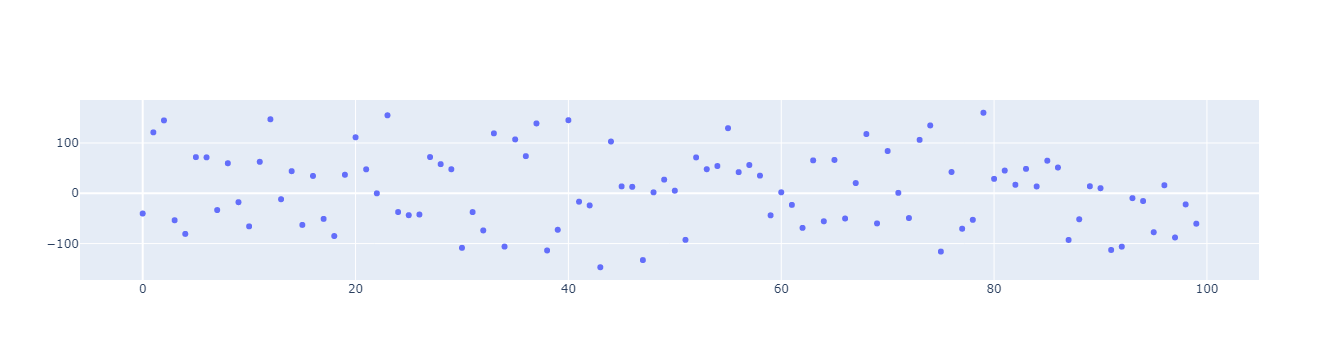

In [133]:
dataloader = load_csv("")
plot(plot_points= [(np.arange(0, len(dataloader["X_train"])), dataloader["Y_train"].to_numpy().reshape(100), "traindata")] )

In [ ]:
# activation function and its derivative
tanh = lambda x: np.tanh(x)
tanh_prime = lambda x: 1-np.tanh(x)**2 
mse = lambda y, y_pred: np.mean((y-y_pred)**2)
mse_prime = lambda y, y_pred : 2*(y_pred - y)/y.shape[0];

# training data
x_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

# x_train = dataloader["X_train"].to_numpy().reshape((dataloader["X_train"].shape[0],1,dataloader["X_train"].shape[1]))
# y_train = dataloader["Y_train"].to_numpy().reshape((dataloader["Y_train"].shape[0],1,dataloader["Y_train"].shape[1]))

# network
model = MLP(optimizer= None, hist= {}, learning_rate=0.1,
            epochs = 1000, eval_step=10, early_stop= False,
            range_flag= False, loss= mse, loss_prime=mse_prime,
            layers=[
                FCLayer(input_size=x_train.shape[2], output_size=3, 
                            activation=tanh, activation_prime=tanh_prime,
                        ),
                FCLayer(input_size=3, output_size=1, 
                            activation=tanh, activation_prime=tanh_prime,
                        ),
                   ],
            )

model.fit(x_train, y_train)

  0%|                                                                                      | 0/1000 [00:00<?, ?it/s]

In [38]:
# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError
        
# inherit from base class Layer
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate):
        
        # print(f"error.shape= {output_error.shape}")
        # print(f"error= {output_error.shape}, W.T= {self.weights.T.shape}")
        # print(f"x.T={self.input.T.shape}, error= {output_error.shape}")
       
        
        
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # dBias = output_error

        # update parameters
        print(f"dW = {weights_error}, db= {output_error}")
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error
    
# inherit from base class Layer
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error
    
# activation function and its derivative
def tanh(x):
    return np.tanh(x);

def tanh_prime(x):
    return 1-np.tanh(x)**2;

# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate):
        # sample dimension first
        samples = len(x_train)

        # training loop
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))
            
# training data
x_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

# x_train = dataloader["X_train"].to_numpy().reshape((dataloader["X_train"].shape[0],1,dataloader["X_train"].shape[1]))
# y_train = dataloader["Y_train"].to_numpy().reshape((dataloader["Y_train"].shape[0],1,dataloader["Y_train"].shape[1]))

# network
net = Network()
net.add(FCLayer(x_train.shape[2], 10))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(10, 1))
net.add(ActivationLayer(tanh, tanh_prime))

# train
net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=1, learning_rate=0.1)

# test
out = net.predict(x_train)
print(out)

dW = [[ 0.0187423 ]
 [-0.08377632]
 [ 0.07978293]
 [-0.13177034]
 [ 0.22361747]
 [ 0.09283401]
 [-0.25815805]
 [-0.26488927]
 [-0.23948734]
 [ 0.03140907]], db= [[-0.59261206]]
dW = [[-0.  0. -0.  0. -0.  0.  0.  0. -0. -0.]
 [-0.  0. -0.  0. -0.  0.  0.  0. -0. -0.]], db= [[-0.02485893  0.27306975 -0.02439339  0.08974973 -0.01158514  0.21333425
   0.11130554  0.16774881 -0.19340832 -0.07161404]]
dW = [[ 0.0661716 ]
 [ 0.35038733]
 [ 0.87322062]
 [ 0.04341744]
 [-0.10091153]
 [-0.27006913]
 [-0.7172301 ]
 [-0.29739816]
 [-1.28232392]
 [-0.74550195]], db= [[-1.75321986]]
dW = [[-0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [-7.02316865e-02  7.77314086e-01 -4.47483557e-02  2.56072389e-01
  -7.57064132e-04  6.47555539e-01  3.00716598e-01  5.57240048e-01
  -3.37555217e-01 -1.69537304e-01]], db= [[-7.02316865e-02  7.77314086e-01 -4.47483557e-02  2.56072389e-01
  -7.5706413